In [ ]:

import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from math import factorial,cos,sin

In [ ]:
class Quadcopter:
  '''
  system constants:
  Z: motor resistor
  Ke: motor constant of voltage
  J: rotor inertia
  Kq: motor constant of torque
  D: drag torque contsant
  n: motor effeciency
  f: propeller figure of merit (iduced power/mechanical power)
  Kt: trust constant
  row: air density
  A: propeller face area
  Ix: inertial arround x
  Iy: inertial arround y
  Iz: inertia arround z
  Rp: rotor blade
  '''
  dt=0.1
  samples=200
  m=0.65
  l=0.19
  Ix=0.0075
  Iy=0.0075
  Iz=0.013
  Rp=0.16
  f=0.5
  J=0.00006
  R=0.6
  Ke=0.0015
  Kq=0.0056
  n=0.75
  Kt=0.01
  g=9.81
  D=0.00000075
  row=1.1
  A= 3.141817*Rp*Rp
  Roll_constant= (2*row*A*l/Iy)*(f*n*Kt/Kq)**2
  Pitch_constant= (2*row*A*l/Ix)*(f*n*Kt/Kq)**2
  xyz_constant= (2*row*A/m)*(f*n*Kt/Kq)**2
  __times=[]
  __v1=0
  __v2=0
  __v3=0
  __v4=0
  __O1=[]
  __O2=[]
  __O3=[]
  __O4=[]
  __roll_h=[]
  __pitch_h=[]
  __yaw_h=[]
  __x_h=[]
  __y_h=[]
  __z_h=[]

  def __init__(self,dt=0.1,samples=200):
    self.dt=dt
    self.samples=samples

  def __diff (self,var,t,history):
  
    if t-self.dt<0:
      varMinusOne = 0
    
    else:
      varMinusOne=history[int((t-self.dt)/self.dt)]
    return (var/self.dt)-(varMinusOne/self.dt)

  def __diff2 (self,var,t,history):

    if t==0:
      varMinusOne = 0
      varMinusTwo = 0

    elif t==self.dt:
      varMinusTwo = 0
      varMinusOne=history[0]
    else : 
      varMinusOne=history[int((t-1*self.dt)/self.dt)]
      varMinusTwo=history[int((t-2*self.dt)/self.dt)]
    ret = var*(1/(self.dt*self.dt))-2*varMinusOne/(self.dt*self.dt) +varMinusTwo/(self.dt*self.dt)
    return ret

  def Omega_f(self,t,V,history):
    if (int(t/self.dt)+1)<=len(history):
      return history[int(t/self.dt)]
    O= sym.Symbol('O')
    equation = (self.R*self.D/self.Kq)*O**2 + (self.R*self.J/self.Kq)*self.__diff(O,t,history)+self.Ke*O -V
    for i in sym.solve(equation,O):
      if i>=0:
        return i

  def Roll_f(self,t,V2,V4,history):
    if (int(t/self.dt)+1)<=len(history):
      return history[int(t/self.dt)]
    Roll= sym.Symbol('Roll')
    equation =self.__diff2(Roll,t,history) -self.Roll_constant*(V2**2 -V4**2)
    ret = sym.solve(equation,Roll)[0]
    return ret

  def Pitch_f(self,t,V1,V3,history):
    if (int(t/self.dt)+1)<=len(history):
      return history[int(t/self.dt)]
    Pitch = sym.Symbol('Pitch')
    equation= self.__diff2(Pitch,t,history) - self.Roll_constant*(V3**2 -V1**2)
    return sym.solve(equation,Pitch)[0]

  def Yaw_f(self,t,V1,V2,V3,V4,history):
    if (int(t/self.dt)+1)<=len(history):
      return history[int(t/self.dt)]
    Yaw = sym.Symbol('Yaw')
    equation = self.__diff2(Yaw,t,history)- (self.J/self.Iz)*(self.__diff(self.Omega_f(t,V1,self.__O1),t,self.__O1) 
                                                    +self.__diff(self.Omega_f(t,V3,self.__O3),t,self.__O3)-self.__diff(self.Omega_f(t,V2,self.__O2),t,self.__O2) 
                                                    -self.__diff(self.Omega_f(t,V4,self.__O4),t,self.__O4))-(self.D/self.Iz)*(self.Omega_f(t,V1,self.__O1)**2 
                                                    + self.Omega_f(t,V3,self.__O3)**2 - self.Omega_f(t,V2,self.__O2)**2 - self.Omega_f(t,V4,self.__O4)**2)
    return sym.solve(equation)[0]

  def X_f(self,t,V1,V2,V3,V4,roll,pitch,yaw,history):
    if (int(t/self.dt)+1)<=len(history):
      return history[int(t/self.dt)]
    x= sym.Symbol("x")
    equation=self.__diff2(x,t,self.__x_h)- self.xyz_constant*(V1**2+V2**2 +V3**2 + V4**2)*(sin(roll)*sin(yaw)+cos(roll)*cos(yaw)*sin(pitch))
    ret = sym.solve(equation,x)[0]
    return ret

  def Y_f(self,t,V1,V2,V3,V4,roll,pitch,yaw,history):
    if (int(t/self.dt)+1)<=len(history):
      return history[int(t/self.dt)]
    y= sym.Symbol("y")
    equation=self.__diff2(y,t,self.__y_h)- self.xyz_constant*(V1**2+V2**2 +V3**2 + V4**2)*(sin(yaw)*sin(pitch)*cos(roll)-cos(yaw)*sin(roll))
    ret = sym.solve(equation,y)[0]
    return ret

  def Z_f(self,t,V1,V2,V3,V4,roll,pitch,yaw,history):
    if (int(t/self.dt)+1)<=len(history):
      return history[int(t/self.dt)]
    z= sym.Symbol("z")
    equation=self.__diff2(z,t,self.__z_h)- self.xyz_constant*(V1**2+V2**2 +V3**2 + V4**2)*(cos(pitch)*cos(roll))+self.g
    ret = sym.solve(equation,z)[0]
    return ret


  def compute (self,V1,V2,V3,V4):
    self.__clear()
    self.__v1=V1
    self.__v2=V2
    self.__v3=V3
    self.__v4=V4
    for i in range (self.samples):
      t = self.dt*i
      self.__times.append (t)
      self.__O1.append(self.Omega_f(t,V1,self.__O1))
      self.__O2.append(self.Omega_f(t,V2,self.__O2))
      self.__O3.append(self.Omega_f(t,V3,self.__O3))
      self.__O4.append(self.Omega_f(t,V4,self.__O4))
      self.__roll_h.append(self.Roll_f(t,V2,V4,self.__roll_h))
      self.__pitch_h.append(self.Pitch_f(t,V1,V3,self.__pitch_h))
      self.__yaw_h.append(self.Yaw_f(t,V1,V2,V3,V4,self.__yaw_h))
      self.__x_h.append(self.X_f(t,V1,V2,V3,V4,self.__roll_h[int(t/self.dt)],self.__pitch_h[int(t/self.dt)],self.__yaw_h[int(t/self.dt)],self.__x_h))
      self.__y_h.append(self.Y_f(t,V1,V2,V3,V4,self.__roll_h[int(t/self.dt)],self.__pitch_h[int(t/self.dt)],self.__yaw_h[int(t/self.dt)],self.__y_h))
      self.__z_h.append(self.Z_f(t,V1,V2,V3,V4,self.__roll_h[int(t/self.dt)],self.__pitch_h[int(t/self.dt)],self.__yaw_h[int(t/self.dt)],self.__z_h))

    for l in range(len(self.__z_h)):
      if self.__z_h[l]<0:
        self.__z_h[l]=0
    self.__plot_data("Roll","rad")
    self.__plot_data("Pitch","rad")
    self.__plot_data("Yaw","rad")
    self.__plot_data("X","rad")
    self.__plot_data("Y","rad")
    self.__plot_data("Z","rad")

  def __clear(self):
      self.__times.clear()
      self.__O1.clear()
      self.__O2.clear()
      self.__O3.clear()
      self.__O4.clear()
      self.__roll_h.clear()
      self.__pitch_h.clear()
      self.__yaw_h.clear()
      self.__x_h.clear()
      self.__y_h.clear()
      self.__z_h.clear()

  def __plot_data(self,title,unit):
    if title =="Angles":
      data=self.__times,self.__roll_h,self.__pitch_h,self.__yaw_h
      max_val= np.max([np.max(data[1]),np.max(data[2]),np.max(data[3])])
      min_val= np.min([np.min(data[1]),np.min(data[2]),np.min(data[3])])
      labels=["Roll","Pitch","Yaw"]
    if title=="Axes":
      data=self.__times,self.__x_h,self.__y_h,self.__z_h
      max_val= np.max([np.max(data[1]),np.max(data[2]),np.max(data[3])])
      min_val= np.min([np.min(data[1]),np.min(data[2]),np.min(data[3])])
      labels=["X","Y","Z"]
    if title =="Roll":
      data=self.__times,self.__roll_h
      max_val= np.max(data[1])
      min_val= np.min(data[1])
      labels=["Roll"]
    if title=="Pitch":
      data=self.__times,self.__pitch_h
      max_val= np.max(data[1])
      min_val= np.min(data[1])
      labels=["Pitch"]
    if title =="Yaw":
      data=self.__times,self.__yaw_h
      max_val= np.max(data[1])
      min_val= np.min(data[1])
      labels=["Yaw"]
    if title=="X":
      data=self.__times,self.__x_h
      max_val= np.max(data[1])
      min_val= np.min(data[1])
      labels=["X"]
    if title =="Y":
      data=self.__times,self.__y_h
      max_val= np.max(data[1])
      min_val= np.min(data[1])
      labels=["Y"]
    if title=="Z":
      data=self.__times,self.__z_h
      max_val= np.max(data[1])
      min_val= np.min(data[1])
      labels=["Z"]
    plt.figure(figsize=(15, 9))
    plt.title(title+" for input V1="+str(self.__v1)+", V2="+str(self.__v2)+", V3="+str(self.__v3)+", V4="+str(self.__v4))
    plt.xlabel("time (s)")
    plt.ylabel("Response"+ unit)
    plt.axis([0, int(np.max(data[0])),int( min_val*10000)/10000, int(max_val*10000)/10000])
    plt.grid(True)
    plt.xticks(range(int(np.max(data[0]))+1))
    # plotting response signals
    plt.plot(data[0],data[1],label =labels[0])
    if title=="Angles" or title=="Axes":
      plt.plot(data[0],data[2],label =labels[1])
      plt.plot(data[0],data[3],label =labels[2])
    plt.legend()
    plt.show()

 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


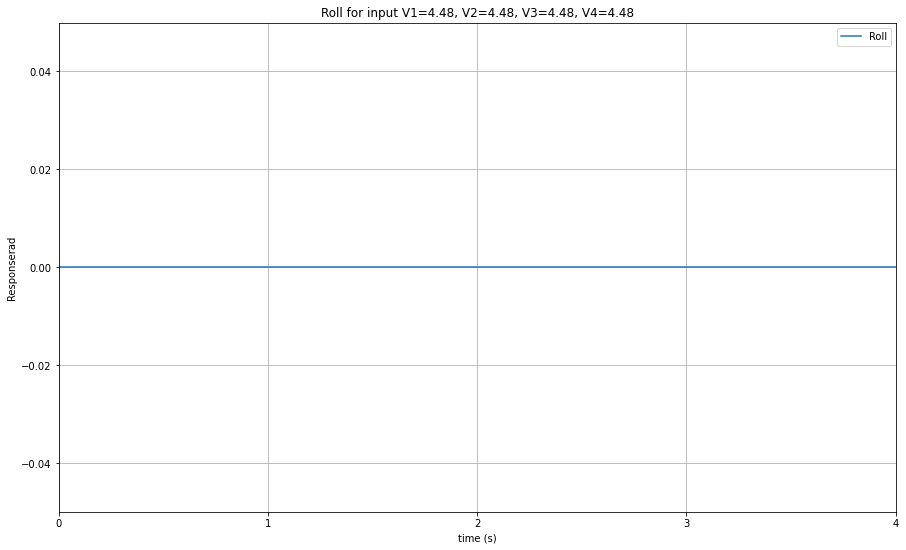

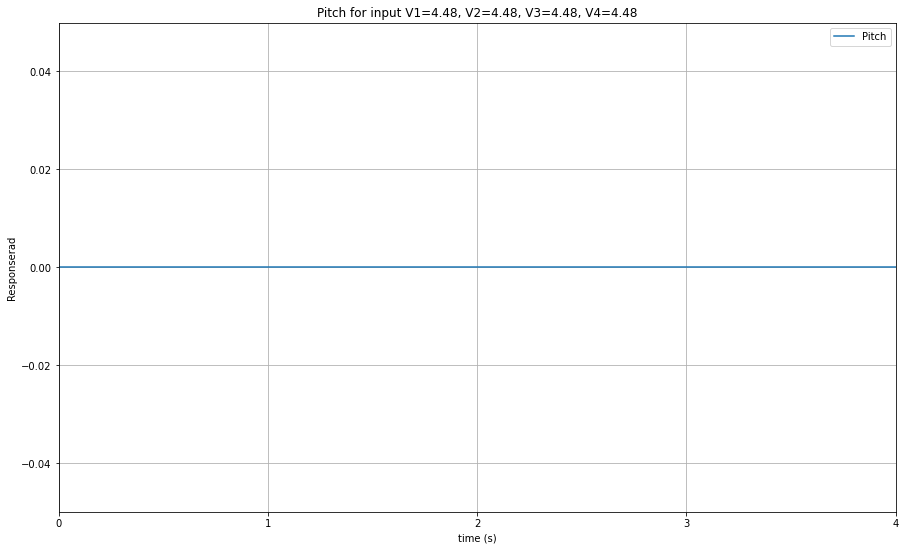

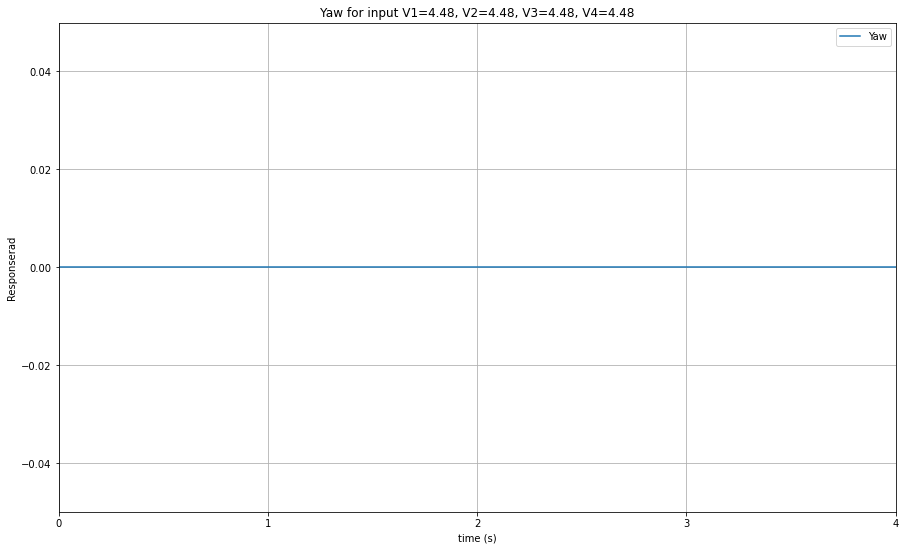

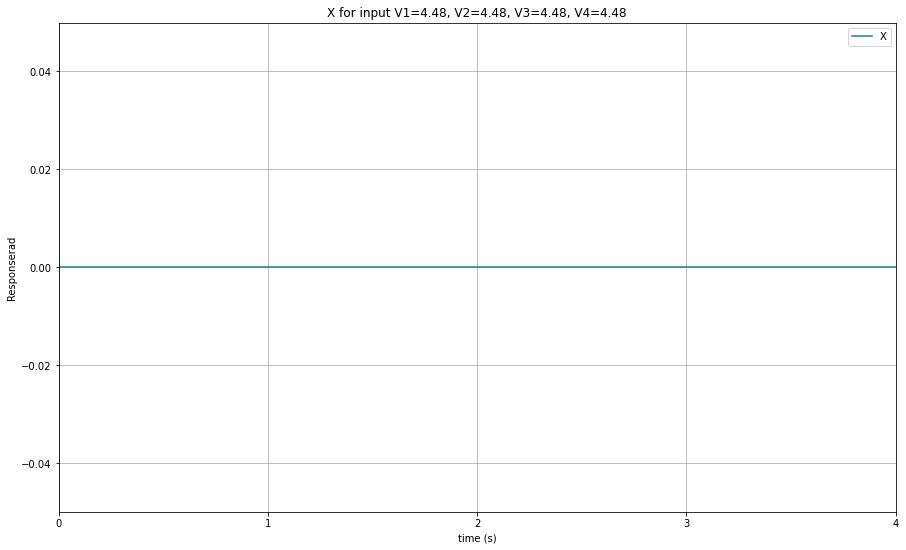

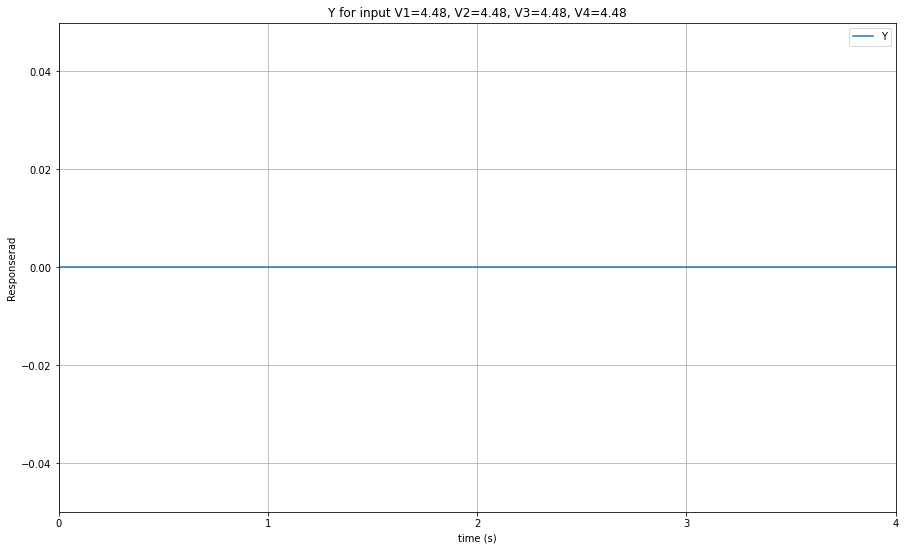

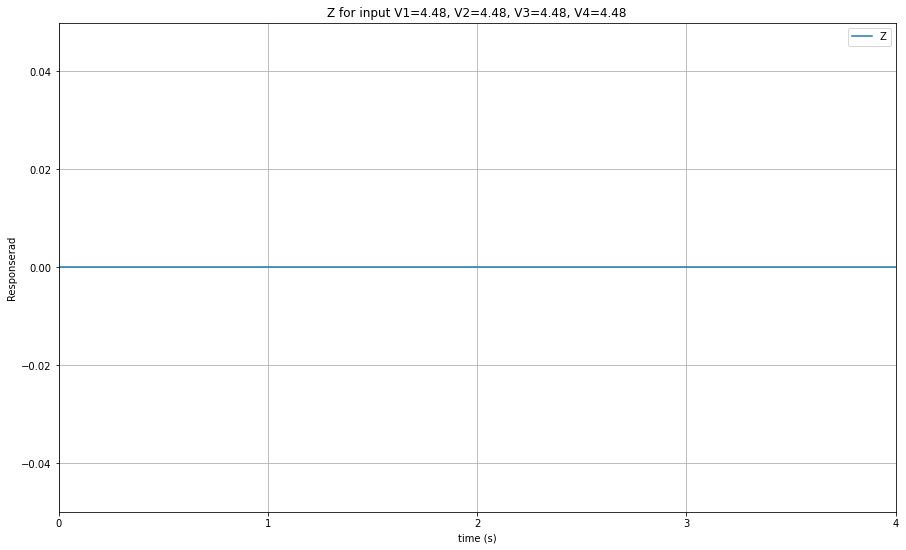

In [ ]:
#Hovering test
test1 = Quadcopter(0.01,401)
test1.compute(4.48,4.48,4.48,4.48)

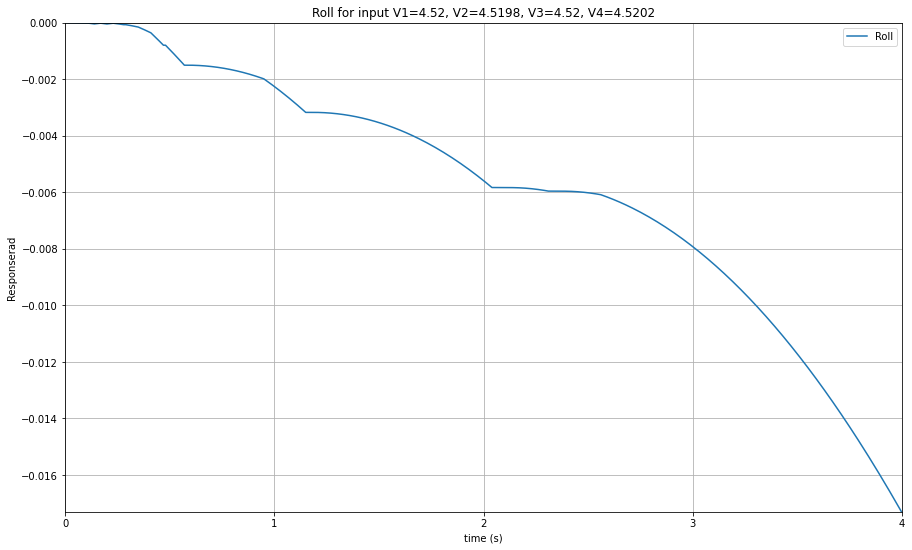

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


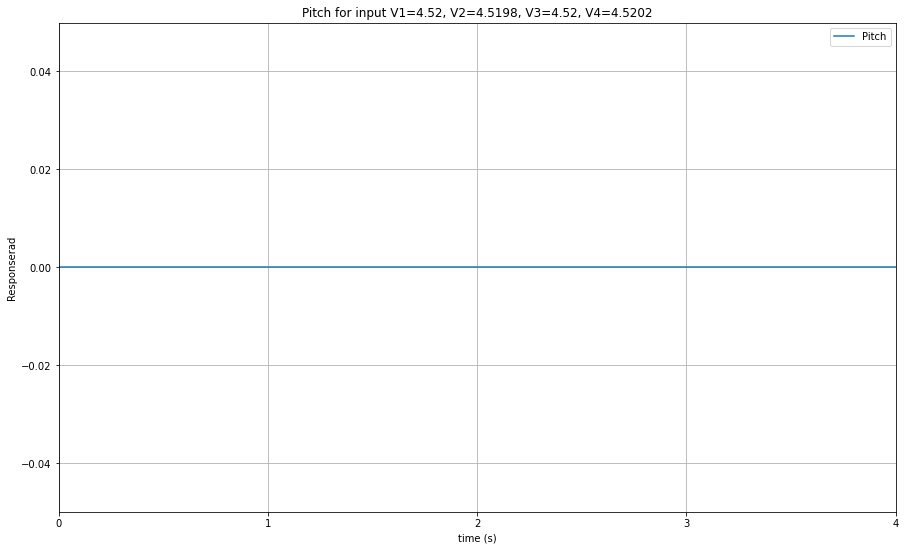

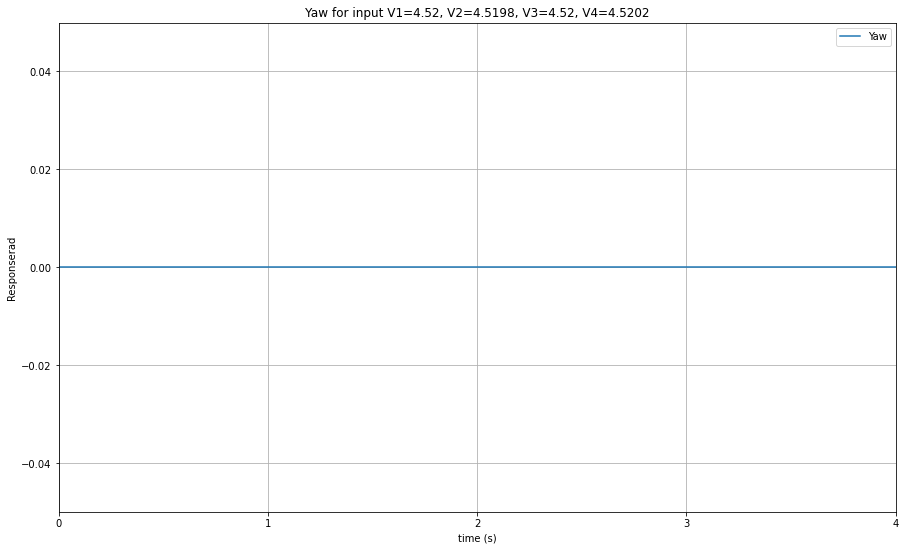

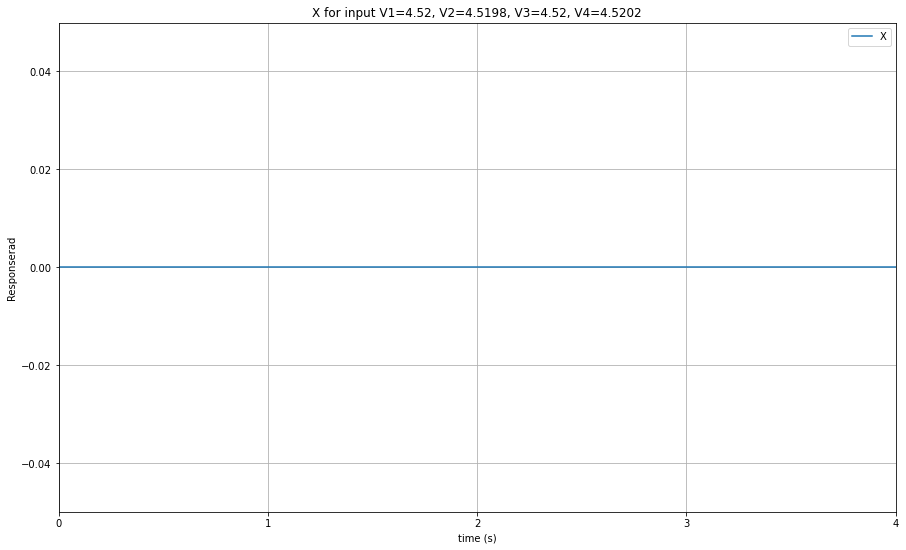

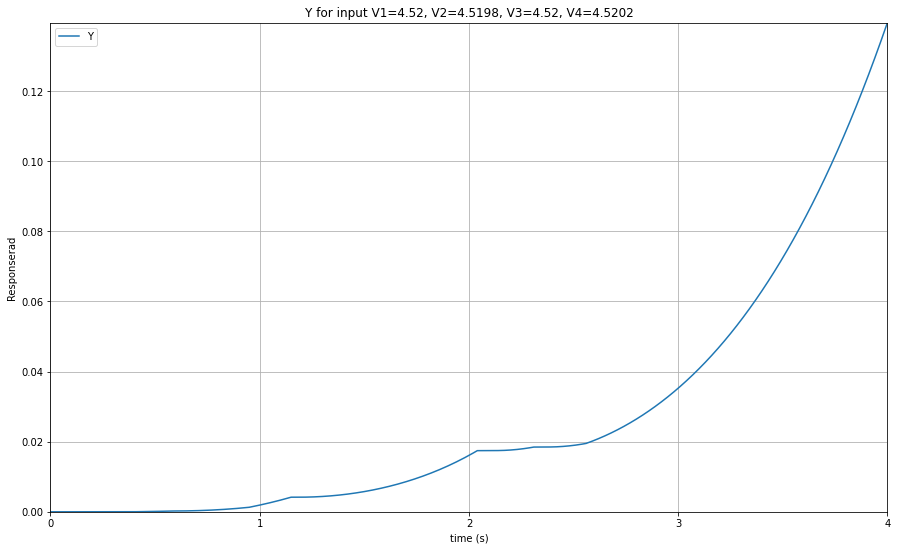

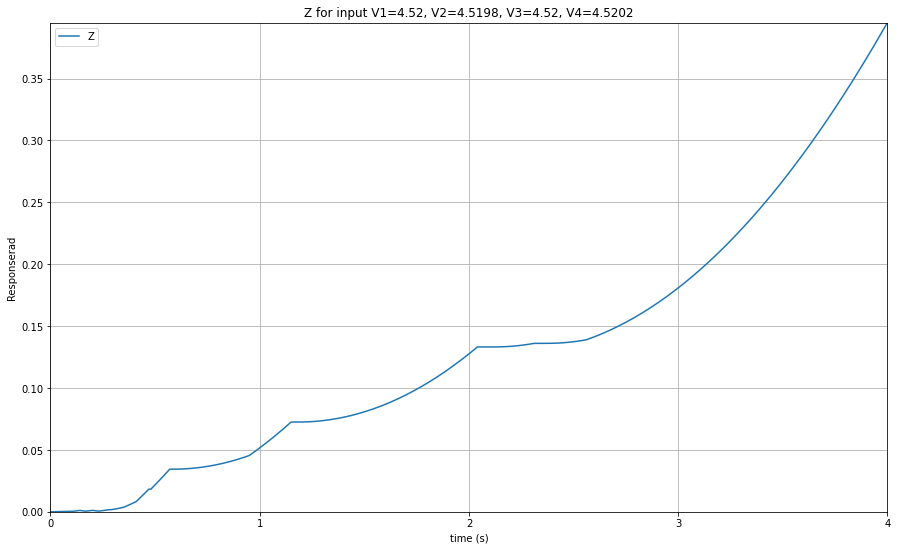

In [ ]:
#positive roll
test2 = Quadcopter(0.01,401)
test2.compute(4.52,4.5198,4.52,4.5202 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


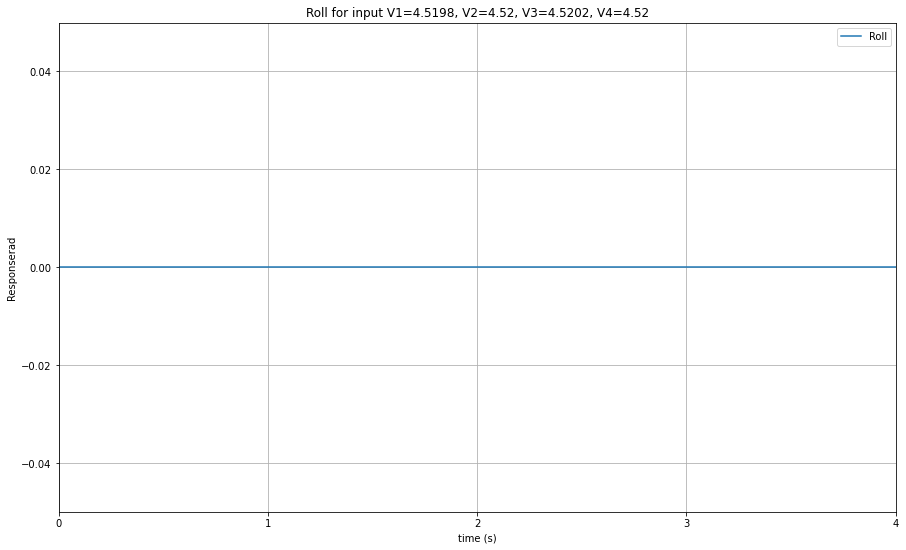

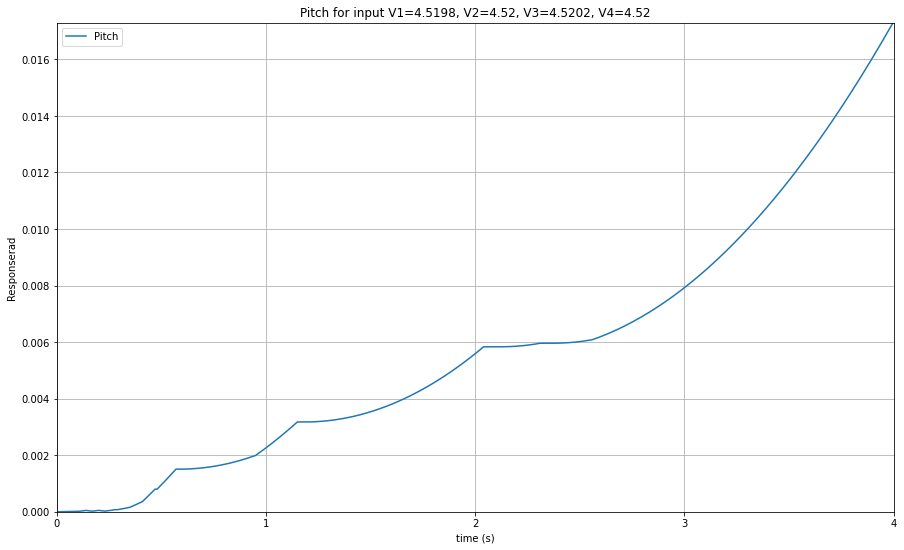

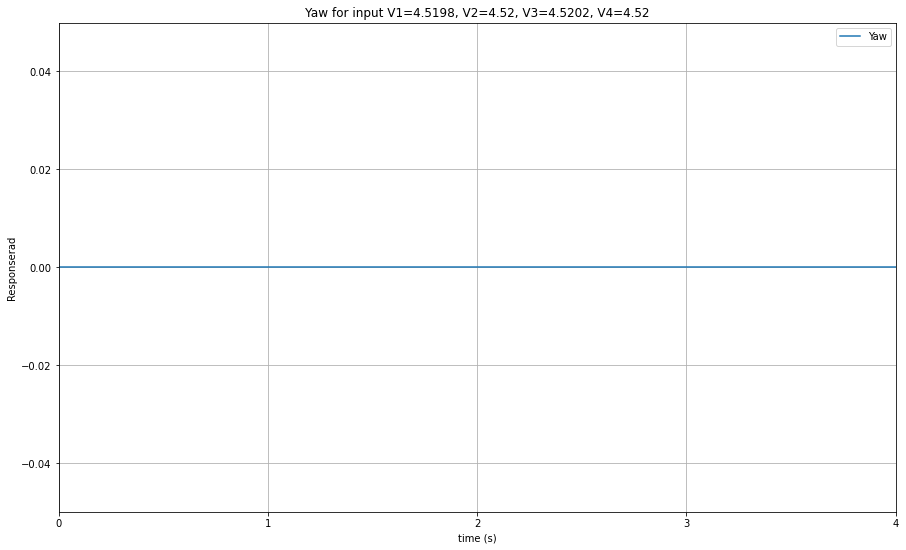

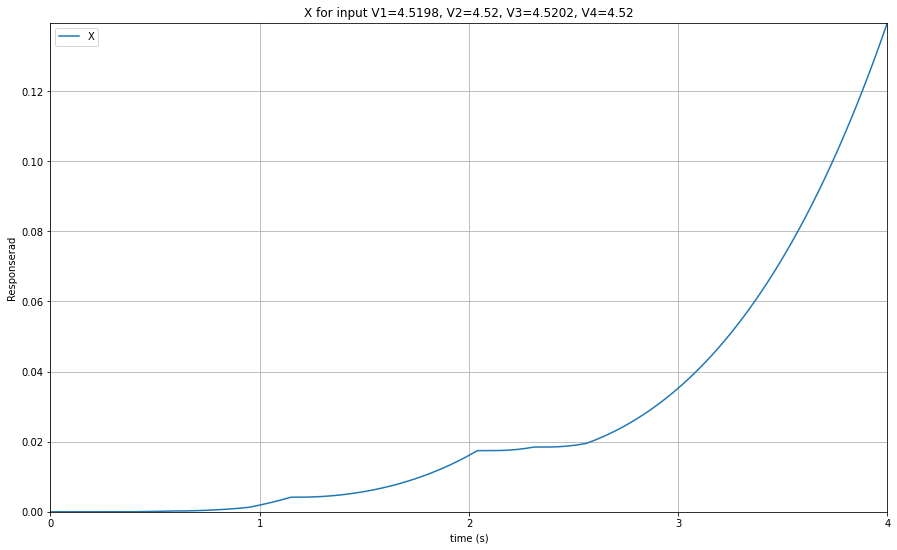

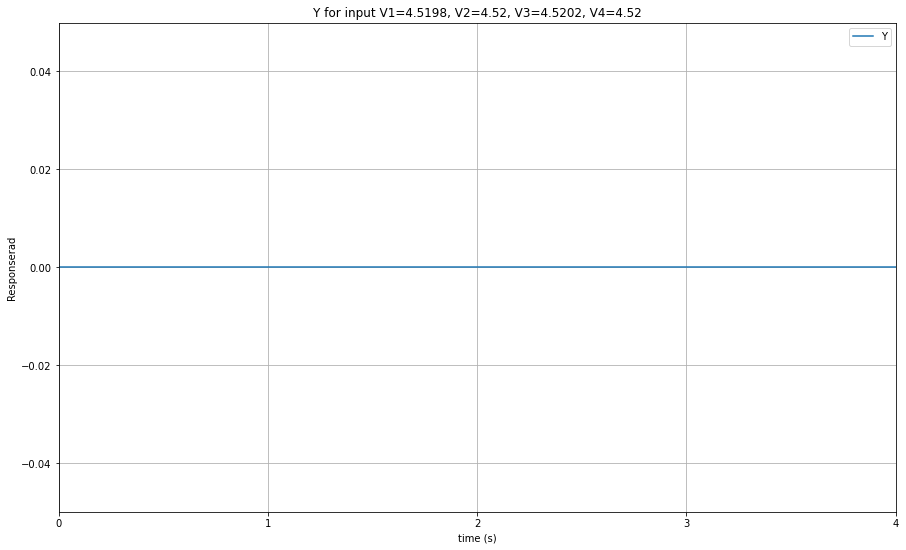

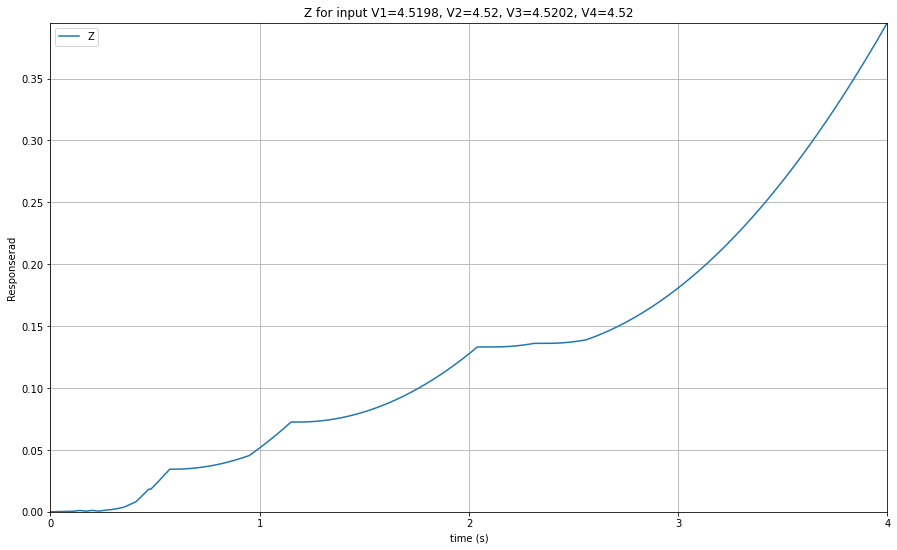

In [ ]:
#positive pitch
test3 = Quadcopter(0.01,401)
test3.compute(4.5198,4.52,4.5202,4.52)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


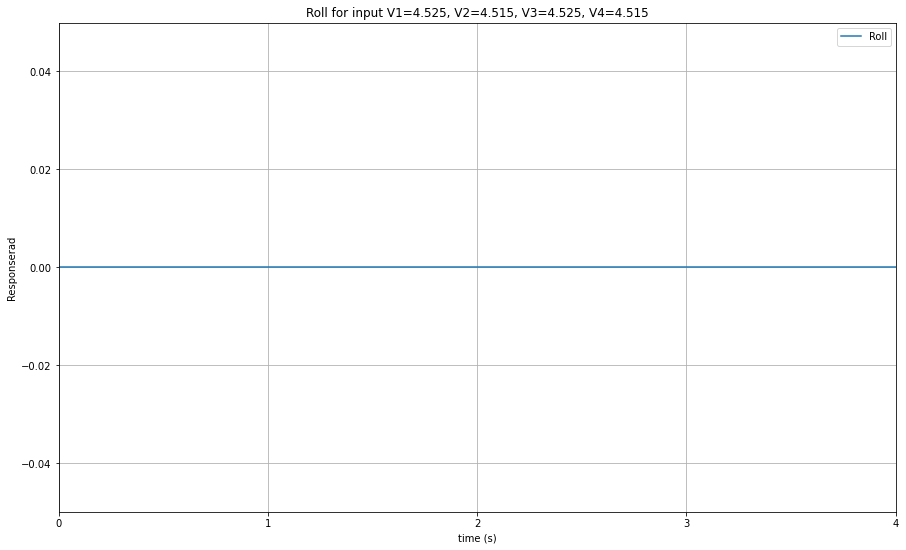

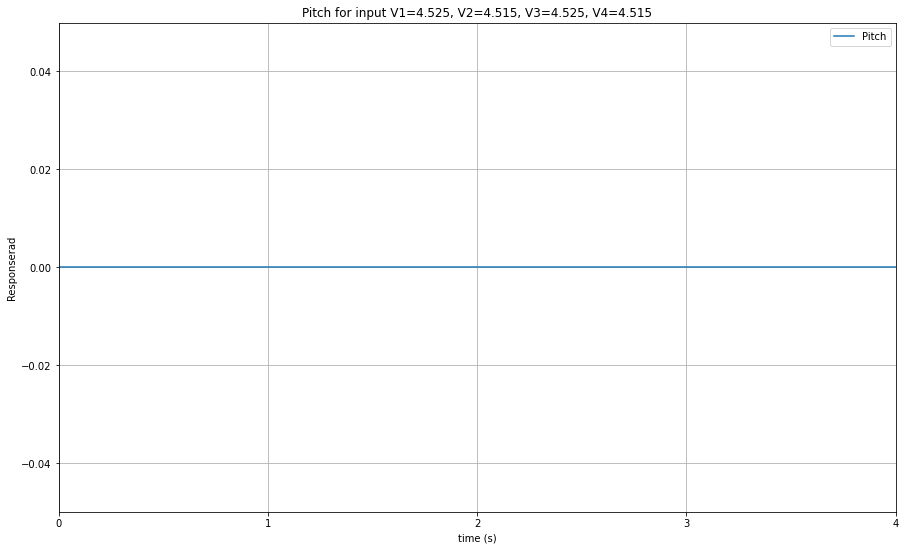

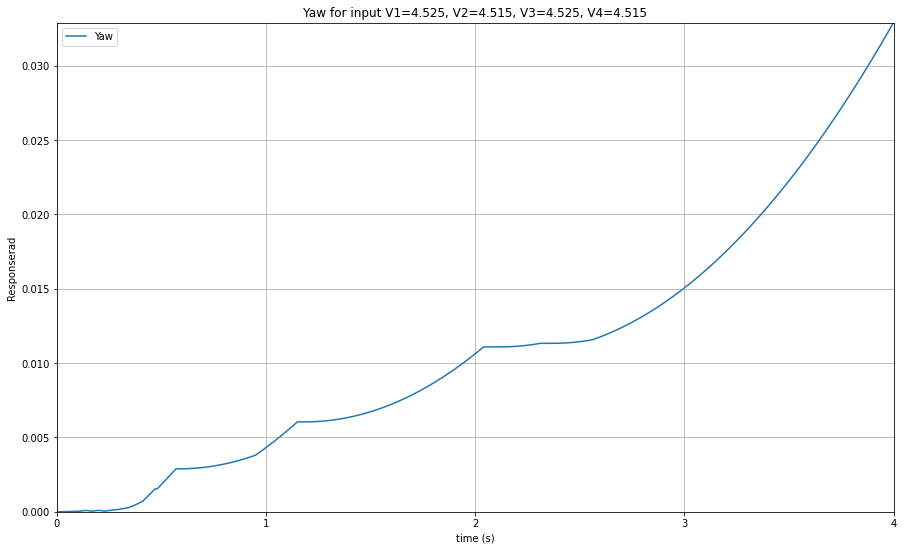

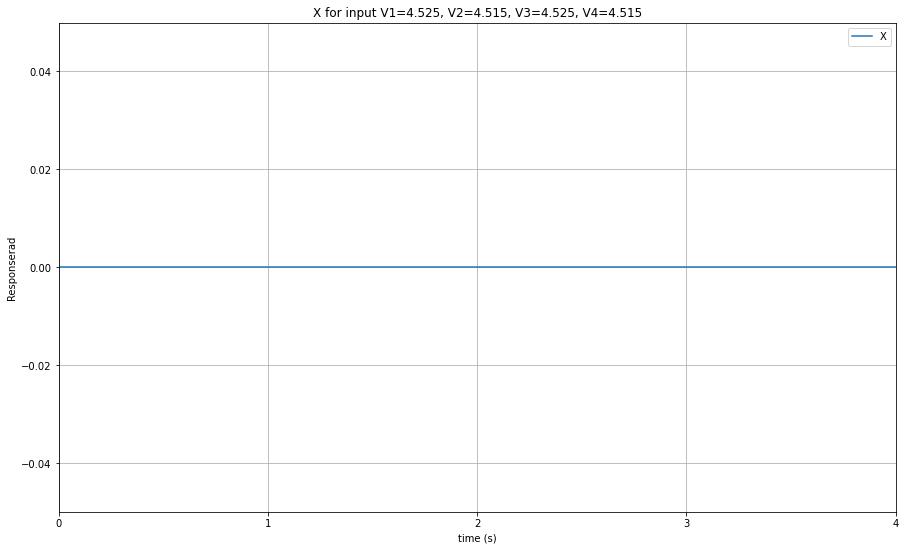

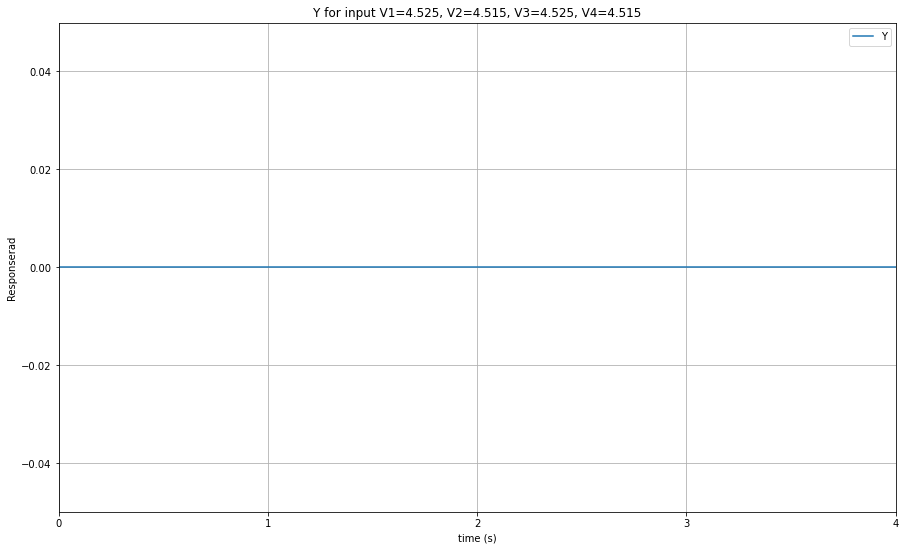

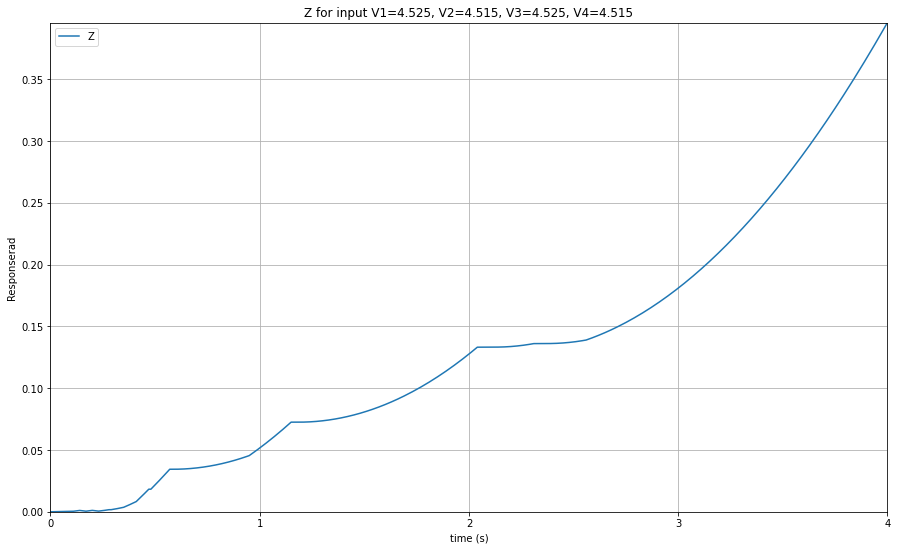

In [ ]:
#positive yaw
test3 = Quadcopter(0.01,401)
test3.compute(4.525,4.515,4.525,4.515)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:232: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


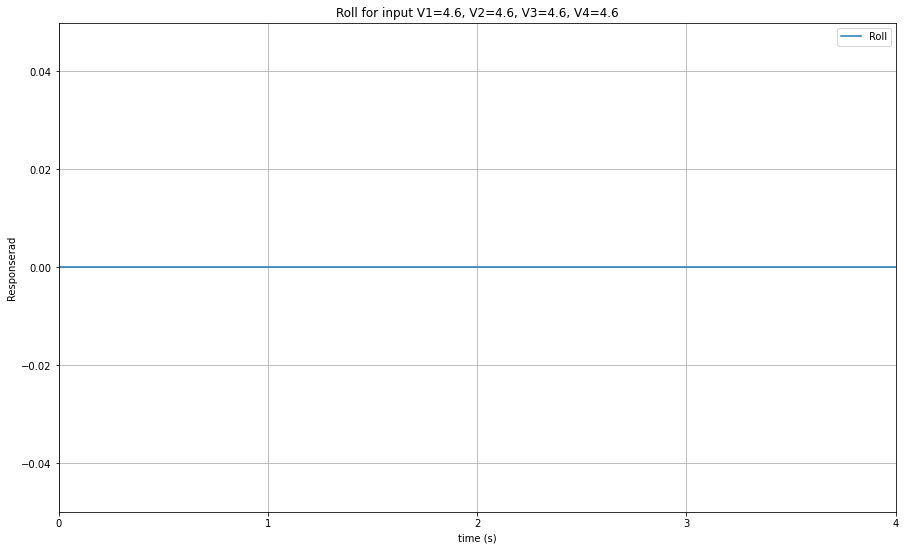

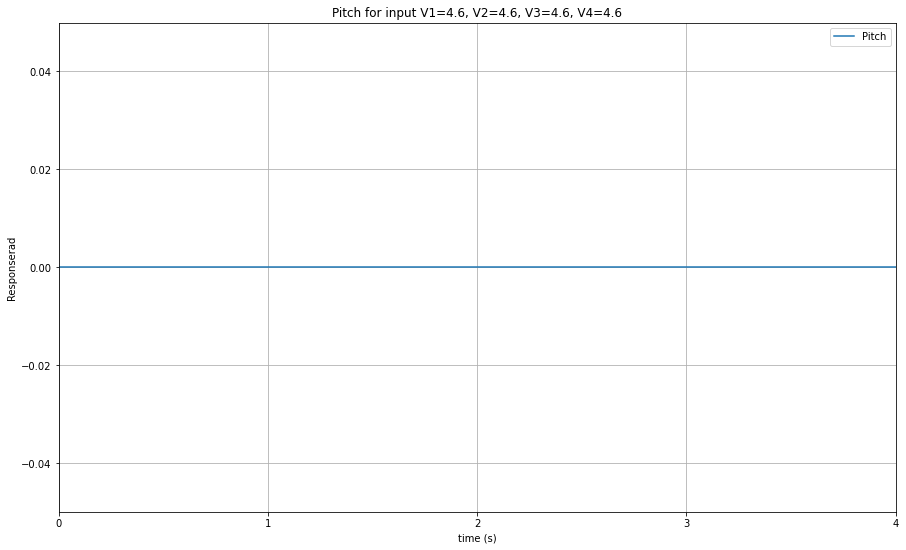

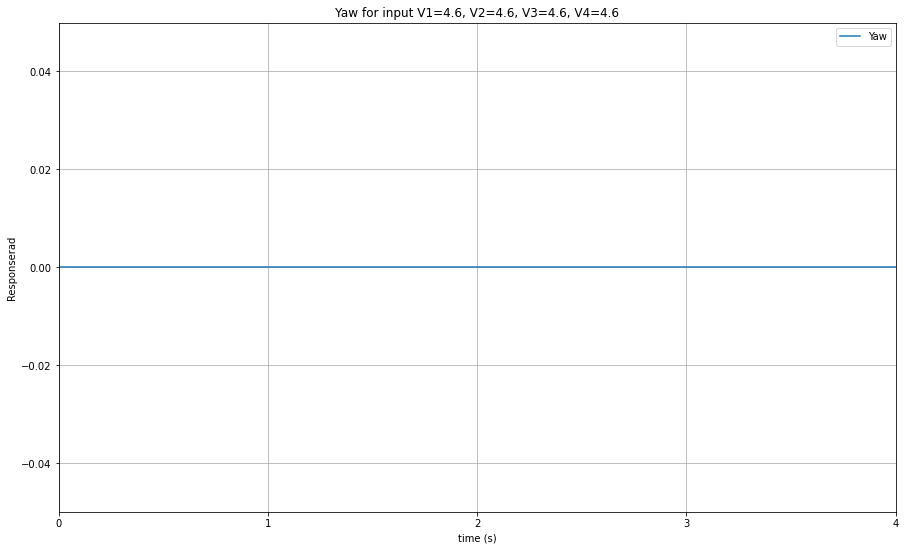

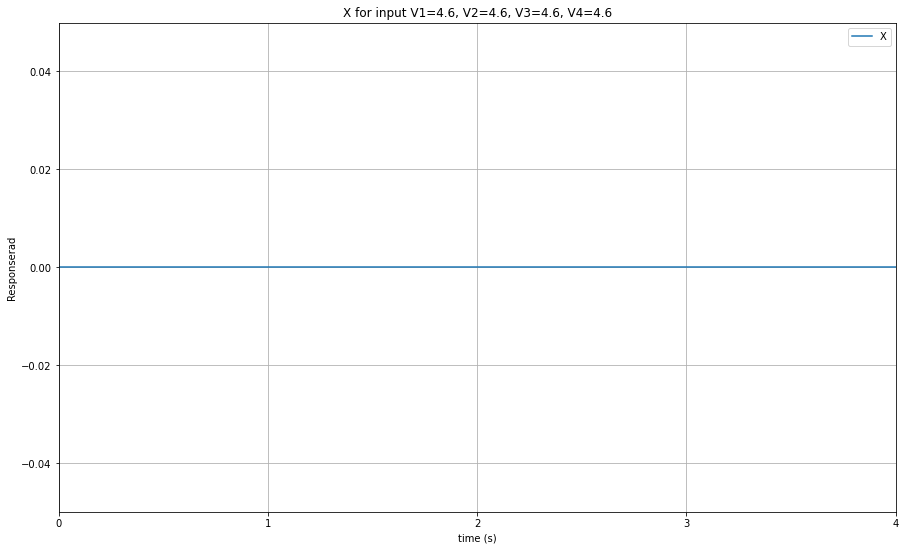

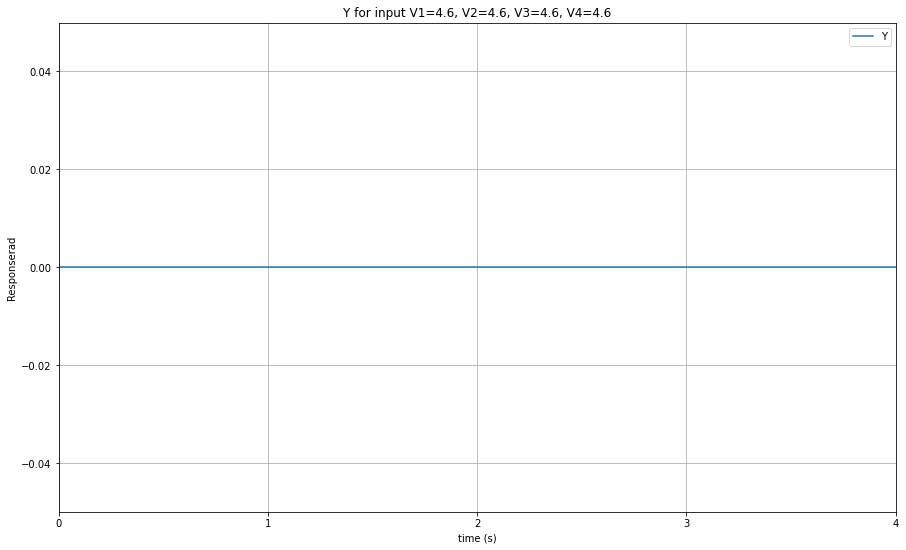

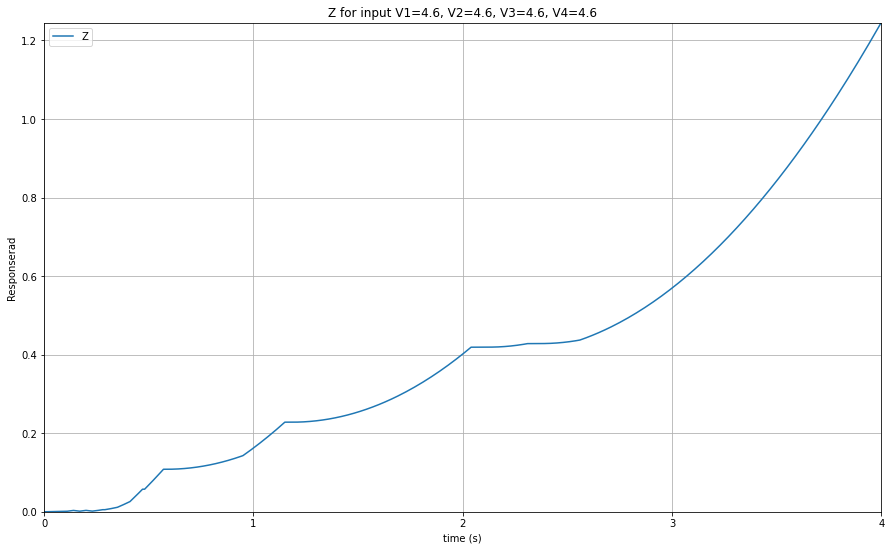

In [ ]:
#vertical climbing
test4 = Quadcopter(0.01,401)
test4.compute(4.6,4.6,4.6,4.6)